<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [2]:
import pandas as pd
import numpy as np
import patsy

from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV, LassoCV,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

import statsmodels.formula.api as sm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

//anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [18]:
business = pd.read_csv("/Users/augustus/Desktop/DSI_notes_assignments/projects/project4/yelp_arizona_data/businesses_small_parsed.csv")



business["is_vegas"] = business["city"] == "Las Vegas"

business.head()

business.drop(["latitude", "longitude", "neighborhoods"], axis = 1)

business.head(1)

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value,is_vegas
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False,False


In [ ]:
business_pivot = business.pivot(index = "business_id", columns = "variable", values = "value")
business = business.drop(["variable", "value"], axis = 1)
business_pivot = business.pivot(index = "business_id", columns = "variable", values = "value")

In [24]:
business = business.drop_duplicates()


business_pivot = business_pivot.reset_index()


business = pd.merge(business, business_pivot, how = "inner", on = "business_id")


In [186]:
#Investigating if there are more spots in vegas open 24 hours on a weeknight in vegas 
#than non-vegas locations.
business.loc[business.is_vegas == True, ["hours.Tuesday.close_y", "hours.Tuesday.open_y"]].head()


,hours.Tuesday.close_y,hours.Tuesday.open_y
196,00:00,00:00
197,00:00,00:00
198,None,None
199,00:00,00:00
200,None,None


In [185]:
business.loc[business.is_vegas == False, ["hours.Tuesday.close_y", "hours.Tuesday.open_y"]].head()

#There are too many missing values for the hours columns

,hours.Tuesday.close_y,hours.Tuesday.open_y
0,None,None
1,None,None
2,22:00,11:00
3,01:00,07:00
4,02:00,11:00


In [25]:
hours_columns = [column for column in business.columns if "hours" in column]

business = business.drop(hours_columns, axis = 1)


In [26]:

attributes_columns = [column for column in business.columns if "attributes" in column]
attributes_columns

#which attributes might be useful for the model?
binary_columns = [column for column in business.columns if len(business[column].unique()) <= 3]

business = business.loc[:, ["stars", "review_count"] + binary_columns]

business = business.fillna(value = 0)
business = business.replace(to_replace = ["True", "False"], value = [1, 0])

business.shape

(152832, 59)

In [28]:
#seperate 
y = business.is_vegas
X = business.loc[:, business.columns != "is_vegas"]

vegas_regression = LogisticRegression()

cross_val_score(vegas_regression, X, y, cv = 10, scoring = "accuracy")

vegas_regression.fit(X,y)




array([  2.83579719e-02,   1.70890623e-03,   3.08846747e-01,
         0.00000000e+00,   1.16656597e-01,   1.27490436e-01,
        -1.22738934e-01,  -1.14596752e-01,   2.87337080e-01,
        -1.13689830e+00,   1.10902504e+00,  -7.46466988e-01,
         1.81147983e-01,   1.30620190e+00,   3.78732716e-01,
        -2.02441200e-01,   6.23390498e-01,   1.88747070e+00,
         2.41964305e-01,   0.00000000e+00,  -3.48343985e-01,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -2.73145043e-01,  -2.29539033e+00,  -4.29493991e-01,
        -2.06596109e-01,   3.60443007e-01,   8.41144655e-01,
        -3.41702080e-01,   5.85125271e-01,   4.49465954e-01,
        -5.69405153e-01,   6.05125019e-01,   2.18160954e-02,
        -3.47475100e-01,  -1.27610453e-01,  -1.54803030e-01,
        -5.20224072e-02,  -5.97786583e-02,  -5.33584391e-01,
         3.76547171e-01,  -1.36449780e-01,  -5.22232331e-01,
         1.41033819e+00,  -5.76259942e-01,  -1.09110823e+00,
         1.41418825e+00,

In [79]:
coeffs = vegas_regression.coef_

coeffs = coeffs.tolist()[0]

def n_max_index (lst, n):
    copy = lst
    output = []
    for _ in range(n):
        if max(copy) > abs(min(copy)):
            output.append(copy.index(max(lst)))
            copy[lst.index(max(lst))] = 0
        else:
            output.append(copy.index(min(lst)))
            copy[lst.index(min(lst))] = 0
    return output
        
topn = n_max_index(coeffs, 10)
predictors = [column for column in  X.columns]


top_predictors = [(predictors[i], coeffs[i]) for i in topn]

#Top 10 most important coefficients in the model
sorted(top_predictors, key = lambda x: x[1])


[('attributes.Dietary Restrictions.vegetarian', -2.2953903335411647),
 ('attributes.Parking.validated', -1.5019388253884087),
 ('attributes.Ambience.romantic', -1.1368982973161363),
 ('attributes.Outdoor Seating', -1.0911082349518868),
 ('attributes.Good For Groups', 0.8411446551638467),
 ('attributes.Ambience.touristy', 1.1090250398341248),
 ('attributes.BYOB', 1.3062019029269818),
 ('attributes.Open 24 Hours', 1.4103381882576034),
 ('attributes.Parking.garage', 1.4141882544244038),
 ('attributes.Corkage', 1.8874706997261828)]

An odd mixture of predictors contribute to the model's classification of restaurants as either in Las Vegas or not. These can be reviewed in the output above. Some of the strongest include: Vegetarian options, which negatively impacts the odds that a restaurant is located in LV. Offering corkage inflates the odds of a LV classification. And lastly, parking validation lowers the odds. I haven't yet had the chance to examine the statistical power of these coefficients or further tune the model to minimize bias. I will if I have time, but I have bigger fish to fry. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [83]:
reviews = pd.read_csv("/Users/augustus/Desktop/DSI_notes_assignments/projects/project4/yelp_arizona_data/reviews_small_nlp_parsed.csv")

reviews.columns

Index([u'user_id', u'review_id', u'votes.cool', u'business_id', u'votes.funny',
       u'stars', u'date', u'votes.useful', u'10 minutes', u'15 minutes',
       ...
       u'service great', u'staff friendly', u'super friendly', u'sweet potato',
       u'tasted like', u'time vegas', u'try place', u've seen', u've tried',
       u'wait staff'],
      dtype='object', length=108)

In [93]:
#k = 0
#for i in reviews.columns:
#    print i, k
#    k += 1
    

#rough sorting of keyword columns     
service_cols = ["10 minutes",
               "15 minutes",
               "30 minutes",
               "bottle service",
               "customer service",
               "dance floor",
               "fast food",
               "friendly staff",
               "good service",
                "great atmosphere",
                "great service",
                "hip hop",
                "minutes later",
                "right away",
                "service excellent",
                "service friendly",
                "service good",
                "service great",
                "staff friendly",
                "super friendly",
                "wait staff"
                 ]

food_cols = ["bar food",
             "beer selection",
             "bloody mary",
             "chicken waffles",
              "eggs benedict",
              "fish chips",
              "food amazing",
              "food delicious",
              "food good",
              "food great",
              "french fries",
              "french toast",
              "fried chicken",
              "good food",
              "great food",
              "hash browns",
              "ice cream",
              "mac cheese",
              "mashed potatoes",
              "medium rare",
              "onion rings",
              "potato fries",
              "quality food",
              "red velvet",
              "tasted like",
              "sweet potato" 
             ]



In [99]:
reviews[service_cols + food_cols].apply(sum, axis= 1).value_counts()
#over half of all reviews don't contain any of the relevant keywords in either the food
#or service columns.

0     186793
1      81731
2      32628
3      12993
4       4880
5       1911
6        769
7        371
8        162
9         79
10        47
11        16
13         8
12         7
14         2
15         1
dtype: int64

In [ ]:
#Given the sparsity of the review keyword data I have two options:
#1. Merge with the tips keyword dataframe
#2. group by user_id to assess their overall interest in service versus food

#I'll try grouping by user_id first, hopefully that will inflate the row counts enough to make
#a good judgement of whether a user is more focused on service or other factors.

In [109]:
reviews.groupby("user_id").sum().apply(sum, axis = 1).value_counts().nlargest(10)

#This is a little better. I should be able to classify users as more or less service focused 
#because the vast majority of users have more than two mentions of any of the keywords.
#Yet I still wouldn't be able to classify individual reviews.

#Maybe if a reviewer is known to be service focused then I could categorize all of his reviews
#as being concerned with service. After that I could, give each business cumulative scores in 
#terms of both service and food. 

#The key (silly) assumption at play for that strategy is that if a reviewer tends to be more
#concerned with service then all of their reviews must be exclusively related to service. I 
#don't see any way around that at this point.



In [112]:
reviews_grouped = reviews.groupby("user_id").sum()



In [151]:
#Now I can aggregate some kind of focus score for each user.
#A good metric for food/interest scores would be proportion of total mentions
reviews_grouped["total_mentions"] = reviews_grouped.iloc[:,4:].sum(axis = 1)

reviews_grouped.total_mentions.value_counts()



0       37015
5       34368
10      23456
15      14859
20       9259
25       6087
30       4000
35       2867
40       2090
45       1556
50       1174
55       1042
60        794
65        640
70        525
75        434
80        367
85        322
95        264
90        264
100       219
110       167
105       157
115       148
120       141
125       114
140       111
130        97
135        95
150        86
        ...  
690         1
1775        1
680         1
1320        1
875         1
560         1
810         1
555         1
1455        1
1070        1
625         1
1825        1
1580        1
1185        1
1220        1
1125        1
1050        1
1690        1
630         1
795         1
1090        1
960         1
1255        1
670         1
1000        1
745         1
800         1
1440        1
1720        1
895         1
Name: total_mentions, dtype: int64

In [152]:
#time to investigate the tips dataset to see if it might be useful to merge with the reviews
#keyword dataset.

tips = pd.read_csv("/Users/augustus/Desktop/DSI_notes_assignments/projects/project4/yelp_arizona_data/tips_small_nlp_parsed.csv")

#UGH this dataset doesn't have the same keyword columns as the reviews set >:-(

#lets 2look at the intersection between the reviews keyword columns and the tips columns

reviews_cols = reviews_grouped.columns.tolist()
tips_cols = tips.columns.tolist()

print len(filter(lambda x: x in tips_cols, reviews_cols)), "columns in common"

#I have a few choices now. I could only focus on the on the columns in the tips dataset that 
#also exist in the reviews dataset. Or I could encorporate all columns from both dataset and 
#then take the time to hand-categorize the keywords into the "service_cols" and "food_cols" 
#list. To help make that decision lets compare the number of unique users for both datasets.



44 columns in common


In [150]:
print "tips shape: ", tips.groupby("user_id").sum().shape
print "reviews shape: ", reviews_grouped.shape

#Reviews has 4x the number of unique users

#Lets look at the intersection of users for both dataframes:

reviews_users = reviews_grouped.index.values.tolist()
tips_users = tips.groupby("user_id").sum().index.values.tolist()

print len(filter(lambda x: x in reviews_users, tips_users))
#The users intersection is 24,869, which is only a small fraction of the total users who review

#I going to just opt to ignore the tips dataframe beause there aren't enough shared users with 
#the reviews frame

tips shape:  (35369, 101)
reviews shape:  (144206, 105)
24869


In [164]:
# Because of the sparsity of the data, i have decided it is impossible to classify every review,
#or even every, user as more focused on service, or non-service aspects. Instead, to generate 
#the partitioned ratings, I am going to only use reviews that are strongly polar.

reviews["service_count"] = reviews[service_cols].sum(axis=1)
reviews["food_count"] = reviews[food_cols].sum(axis=1)

#time to create that metric for choosing polar reviews. positive polarity values indicate 
#interest in service and vice versa.
reviews["polarity"] = reviews.service_count - reviews.food_count

reviews.polarity.value_counts()

#I semi-arbitrarily pick |3| as the cut off for polar reviews
reviews["service_focused"] = reviews.polarity.map(lambda x: x >= 3)
reviews["food_focused"] = reviews.polarity.map(lambda x: x <= -3)

reviews[["service_focused", "food_focused"]].sum()
#This leaves us ~9500 polar reviews to construct partitioned yelp ratings 

service_focused    3244
food_focused       6291
dtype: int64

In [195]:
def partition_stars_service(row):
    if row.values[111]:
        return row.values[5]
    else:
        return None
    
def partition_stars_food(row):
    if row.values[112]:
        return row.values[5]
    else:
        return None
    
#finally create the service and food rating columns
reviews["service_rating"] = reviews.apply(partition_stars_service, axis=1)
reviews["food_rating"] = reviews.apply(partition_stars_food, axis=1)



In [204]:
reviews.groupby("business_id")[["service_rating", "food_rating"]].mean().notnull().sum()


#There are far too many businesses that still do not have a single polar review. About 3/4
#of the business are null. This was my fault because my definition of a service related review
#was a bit too precise, but as far as I'm concerned loosening up the criteria would render 
#modeling that data totally un-informative.

service_rating    986
food_rating       903
dtype: int64

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [104]:
users = pd.read_csv("/Users/augustus/Desktop/DSI_notes_assignments/projects/project4/yelp_arizona_data/users_small_parsed.csv")

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Extend the `LinearRegrssion` class to include the following: 

- Calculate confidence intervals at X% on the $\beta$ coefficients and predicted y value when the model is not regularized. Here is a good overview of calculating confidence intervals: http://imgur.com/a/O1ZFk



- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]

Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the `NearestNeighbor` class such that the fit method doesn't use a `for loop`


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 8. Implement `LogisticRegression` that fits the model using Stochastic Gradient Descent. 

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 9. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test set when you apply it on the raw dataset vs. the compressed version of dataset from SVD. 

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
from PIL import Image

(70000, 784)


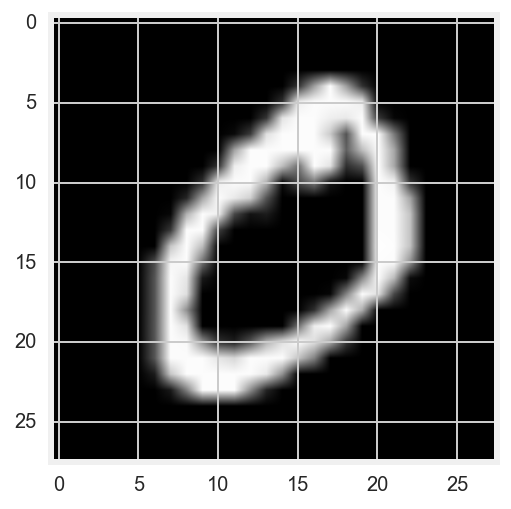

In [5]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

mnist_data = mnist["data"]
print mnist_data.shape

mnist_data_shaped = np.reshape(mnist_data, (70000, 28, 28))

plt.imshow(mnist_data_shaped[0,:,:], cmap = "gray")

In [256]:
dig = mnist_data_shaped[0,:,:]


In [258]:
U, sigma, V = np.linalg.svd(dig)

In [24]:
reconst_dig = np.matrix(U[:, :3]) * np.diag(sigma[:3]) * np.matrix(V[:3, :])
plt.imshow(reconst_dig, cmap='gray');
#cool!

NameError: name 'U' is not defined

In [14]:
#fitting a model on a 7000 images will be way too computationally expensive. Before I fit on 
#compressed images, I will have to fit on a sample from the database. I believe the digits 
#are placed in sequential order in the mnist data, so it is important to randomly sample.

mnist_frame = pd.DataFrame(mnist_data)
mnist_frame["target"] = mnist["target"]

#randomly sample 1/10 of the mnist data for training
X = mnist_frame.sample(frac = 0.1)

y = X["target"]

In [16]:
X = X.drop("target", axis = 1)

In [25]:
reg_uncompressed = LogisticRegression()
reg_uncompressed.fit(X,y)

#Warning this might take awhile
cross_val_score(reg_uncompressed, X, y, cv = 5, n_jobs = -1)

KeyboardInterrupt: 

In [34]:
#Time to try compressing the imagedata

def svd_compress(image_vector, n_dim = 50, preview = False):
    """
    compresses a 1-d mnist image vector to the n_dim singular values.
    """
    image_matrix = np.reshape(image_vector, (28,28))
    U, sigma, V = np.linalg.svd(image_matrix)
    
    reconst_image = np.matrix(U[:, :n_dim]) * np.diag(sigma[:n_dim]) * np.matrix(V[:n_dim, :])
    
    if preview:
        plt.imshow(reconst_image, cmap='gray')
    
    return np.reshape(reconst_image, (784))

#svd_compress(mnist_data[62000, :], preview = True)



In [44]:
np.apply_along_axis(svd_compress, 1, mnist_data)



ValueError: could not broadcast input array from shape (784) into shape (1)

## Optional: Interview Practice

## Coding Questions 
- Implement Binary Search in Python and write down the algorithmic complexity of the Binary Search Algorithm.


- Implement Merge Sort in Python [Hint: First implement the `merge` function that combines two sorted arrays into one sorted array linear time]. What is the time complexity of `mergesort` ?


- Find the closest pair from two sorted arrays. Given two sorted arrays and a number x, find the pair whose sum is closest to x and the pair has an element from each array. We are given two arrays ar1[0…m-1] and ar2[0..n-1] and a number x, we need to find the pair ar1[i] + ar2[j] such that absolute value of (ar1[i] + ar2[j] – x) is minimum. What is the time complexity of this algorithm?

In [100]:
#Binary search

sample_list = [10, 16, 19, 22, 43, 98, 101]
sample_num = 98

def binary_search(num, search_list):
    length = len(search_list)
    min_index = 0
    max_index = length - 1 
    guess = 0
    
    while guess != num:
        guess_index = (max_index + min_index) / 2
        guess = search_list[guess_index]
        if num > guess:
            min_index = guess_index
        elif num < guess:
            max_index = guess_index
        elif min_index == max_index:
            return False
            break
            
    else:
        return guess_index
    
binary_search(sample_num, sample_list)


#time complexity: log2(n)? 

5

In [136]:
sample_list = list(np.random.randint(0, 20, size = 20))

In [167]:
#MergeSort

sample_list_1 = range(20)
sample_list_2 = map(lambda x: x * 3, range(23))


sorted_list = []

def merge(list1, list2):
    
    if len(list1) == 0:
        sorted_list = sorted_list + list2 
        return None
    
    elif len(list2) == 0:
        sorted_list = sorted_list +  list1
        return None
    
    if list1[0] > list2[0]:
        sorted_list.append(list2[0])
        merge(list1, list2[1:])
        
        
    else:
        sorted_list.append(list1[0])
        merge(list1[1:], list2)

merge([4, 7, 9 , 12], [9, 18, 24, 98])

print sorted_list



UnboundLocalError: local variable 'sorted_list' referenced before assignment

In [ ]:
def MergeSort(random_list):
    
    while len(random_list) != 0:
        output.append(merge([random_list[0]], [random_list[1]]))
        MergeSort(random_list[0:2])
#    MergeSort(sample_list_3)      
        


In [146]:
sorted_list = []
def merge2(list1, list2):
    if len(list1) and len(list2) == 0:
        return None
    if list1[0] > list2[0]:
        sorted_list.append(list1[0])
        merge2(list1[1:], list2)
    else:
        sorted_list.append(list2[0])
        merge2(list1,list2[1:])

merge2(sample_list_1, sample_list_2)

sorted_list

[0,
 3,
 6,
 9,
 12,
 15,
 18,
 21,
 24,
 27,
 30,
 33,
 36,
 39,
 42,
 45,
 48,
 51,
 54,
 57,
 60,
 63,
 66]

## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?
    - The probability of not seeing a shooting star in an hour is 0.8^4 = 0.4096
    - So the probability of seeing at least one star is 1 - 0.4096 = 0.5904


- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?
    - 0.5? If order doesn't matter.
    - 1/3 if order does matter.


## Interview Questions Related to Material

- *Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance? *

    - Bias measures a model's ability to accurately make predictions given ideal information. 
    - Variance is how unpredictable a model is depending on which data it's trained on
    - Useful because it helps you tune the sensitivity of your model. Is the model too sensitive to noise (high variance)? Is it complicated enough to capture the structure of the data (high bias).  
    
    
- *Explain why cross-validation is important.* 
    - A single training set might not accurately reflect the features of a test set. To evaluate a model, the train / test process should be repeated many times to balance out any funky splits that might have happened due to chance. 

- *What is regularization? What are the advantages/disadvantages of different types of regularization schemes?* 
    - Regularization throttles over-fitting (keeps variance low). It is an automatic method to keep your model as simple (parsimonious as possible). 
    - For regressions there are three main regularization algorithms.
        - Ridge: Minimizes l2 norm of the parameters.
        - Lasso: Minimizes l1 norm of the parameters. More agressively throttles the size of coefficients than Ridge. 
        - ElasticNet: A combination of Ridge and Lasso. 


- *What are the loss functions associated with linear regression, logistic regression, and KNN?* 
    - Linear regression: The sum of squared difference between the true values and the predicted values. 
    - Logistic regression (binary): Sum of difference between true outcome and its predicted probability (?).   


- *Can you give examples of feature engineering on datasets you have worked with?* 
    - In the iowa liquor dataset, I made courser categories for liquor type. 
    - Add a quadratic term to a linear regression when the relationship doesn't seem linear in the data. 